# Gaussian processes (3/3) - exploring kernels

This post will go more in-depth in the kernels fitted in [our example fitting a Gaussian process to model atmospheric CO₂ concentrations]({% post_url /blog/gaussian_process/2019-01-06-gaussian-process-kernel-fitting %}). We will describe and visually explore each part of the kernel used in our fitted model, which is a combination of the exponentiated quadratic kernel, exponentiated sine squared kernel, and rational quadratic kernel. This post is the last part of a series on Gaussian processes:

1. [Understanding Gaussian processes]({% post_url /blog/gaussian_process/2019-01-05-gaussian-process-tutorial %})
2. [Fitting a Gaussian process kernel]({% post_url /blog/gaussian_process/2019-01-06-gaussian-process-kernel-fitting %})
3. [Gaussian process kernels (this)]({% post_url /blog/gaussian_process/2019-01-07-gaussian-process-kernels %})

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter("ignore")

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

sns.set_style('darkgrid')
np.random.seed(42)
tf.random.set_seed(42)
#

## Kernel function

A kernel (or covariance function) describes the [covariance](https://en.wikipedia.org/wiki/Covariance) of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.

In the [first post]({% post_url /blog/gaussian_process/2019-01-05-gaussian-process-tutorial %}) we introduced the concept of the kernel which defines a prior on the Gaussian process distribution. To summarize the kernel function $k(x, x')$ models the covariance between each pair in $x$. The kernel function together with the mean function $m(x)$ define the Gaussian process distribution:

$$y \sim \mathcal{GP}(m(x),k(x,x'))$$


### Valid kernels
In order to be a valid kernel function the resulting kernel matrix $\Sigma = k(X, X)$ should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Which implies that the matrix should be [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix). Being positive definite also means that the kernel matrix is [invertible](https://en.wikipedia.org/wiki/Invertible_matrix).

The process of defining a new valid kernel from scratch it not always trivial. Typically pre-defined kernels are used to model a variety of processes. In what follows we will visually explore some of these pre-defined kernels that we used in our [fitting example]({% post_url /blog/gaussian_process/2019-01-06-gaussian-process-kernel-fitting %}).

In [2]:
# Plotting function to be used below

def plot_kernel(X, y, Σ, description, fig, subplot_spec, xlim,
                scatter=False, rotate_x_labels=False):
    """Plot kernel matrix and samples."""
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        wspace=0.18, hspace=0.0,
        subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(grid_spec[0])
    ax2 = fig.add_subplot(grid_spec[1])
    # Plot samples
    if scatter:
        for i in range(y.shape[1]):
            ax1.scatter(X, y[:,i], alpha=0.8, s=3)
    else:
        for i in range(y.shape[1]):
            ax1.plot(X, y[:,i], alpha=0.8)
    ax1.set_ylabel('$y$', fontsize=13, labelpad=0)
    ax1.set_xlabel('$x$', fontsize=13, labelpad=0)
    ax1.set_xlim(xlim)
    if rotate_x_labels:
        for l in ax1.get_xticklabels():
            l.set_rotation(30)
    ax1.set_title(f'Samples from {description}')
    # Plot covariance matrix
    im = ax2.imshow(Σ, cmap=cm.YlGnBu)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.02)
    cbar = plt.colorbar(im, ax=ax2, cax=cax)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=8)
    ax2.set_title(f'Covariance matrix\n{description}')
    ax2.set_xlabel('X', fontsize=10, labelpad=0)
    ax2.set_ylabel('X', fontsize=10, labelpad=0)
    # Show 5 custom ticks on x an y axis of covariance plot
    nb_ticks = 5
    ticks = list(range(xlim[0], xlim[1]+1))
    ticks_idx = np.rint(np.linspace(
        1, len(ticks), num=min(nb_ticks,len(ticks)))-1).astype(int)
    ticks = list(np.array(ticks)[ticks_idx])
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)
    if rotate_x_labels:
        for l in ax2.get_xticklabels():
            l.set_rotation(30)
    ax2.grid(False)
#

## White noise kernel

The [white noise](https://en.wikipedia.org/wiki/White_noise) kernel represents independent and identically distributed noise added to the Gaussian process distribution.

$$k(x, x) = \sigma^2 I_n$$
With:
* $\sigma^2$ the variance of the noise.
* $I_n$ the identity matrix.

This formula results in a covariance matrix with zeros everywhere except on the diagonal of the covariance matrix. This diagonal contains the variances of the individual random variables. All covariances between samples are zero because the noise is uncorrelated.

Samples from the white noise kernel together with a visual representation of the covariance matrix are plotted in the next figure.

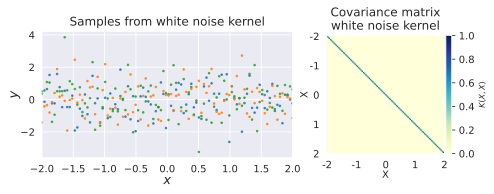

In [3]:
# Plot kernel matrix and samples of white noise kernel

nb_of_samples = 100  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate independent samples that can be transformed
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 2.7))
gs = gridspec.GridSpec(
    1, 1, figure=fig, wspace=0.0, hspace=0.0)

# Sample from the prior
Σ = np.eye(nb_of_samples)  # Identity matrix
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
# Plot
plot_kernel(
    X, y, Σ, 'white noise kernel',
    fig, gs[0], xlim, scatter=True)
fig.tight_layout()
plt.show()
#

## Exponentiated quadratic kernel

The [exponentiated quadratic](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/ExponentiatedQuadratic) kernel (also known as squared exponential kernel, Gaussian kernel or radial basis function kernel) is one of the most popular kernels used in Gaussian process modelling. It can be computed as:

$$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{ \left\Vert x_a - x_b \right\Vert^2}{2\ell^2}\right)$$
With:
* $\sigma^2$ the overall variance ($\sigma$ is also known as amplitude).
* $\ell$ the lengthscale.

Using the exponentiated quadratic kernel will result in a [smooth](https://en.wikipedia.org/wiki/Smoothness) prior on functions sampled from the Gaussian process.


The exponentiated quadratic is visualized in the next figures. The first figure shows the distance plot with respect to $0$: $k(0, x)$. Note that the similarity outputted by the kernel decreases exponentially towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $x_a = x_b$.

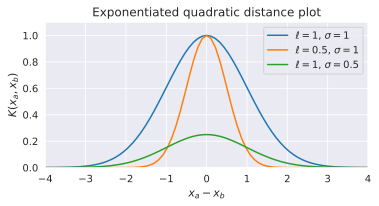

In [4]:
# Plot exponentiated quadratic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=75), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell = 1$, $\\sigma = 1$')
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell = 0.5$, $\\sigma = 1$')
Σ =  tfk.ExponentiatedQuadratic(amplitude=0.5, length_scale=1.).matrix(zero, X).numpy()

ax.plot(X[:,0], Σ[0,:], label='$\\ell = 1$, $\\sigma = 0.5$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Exponentiated quadratic distance plot')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

The following figure shows samples from the exponentiated quadratic kernel together with a visual representation of its covariance matrix.

Observe in the previous and following figure that increasing the lengthscale parameter $\ell$ increases the spread of the covariance. Increasing the amplitude parameter $\sigma$ increases the maximum value of the covariance.

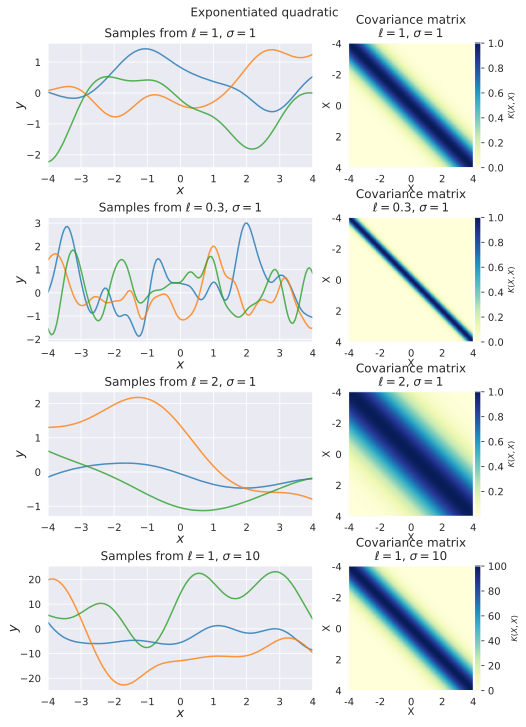

In [5]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 10))
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell = 1$, $\\sigma = 1$',
    fig, gs[0], xlim)

# Plot second
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=0.3).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell = 0.3$, $\\sigma = 1$',
    fig, gs[1], xlim)

# Plot second
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=2.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell = 2$, $\\sigma = 1$',
    fig, gs[2], xlim)

# Plot third
Σ = tfk.ExponentiatedQuadratic(amplitude=10., length_scale=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell = 1$, $\\sigma = 10$',
    fig, gs[3], xlim)

plt.suptitle('Exponentiated quadratic', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.04, right=0.93, top=0.94)
plt.show()
#

## Rational quadratic kernel

$$k(x_a, x_b) = \sigma^2 \left( 1 + \frac{ \left\Vert x_a - x_b \right\Vert^2}{2 \alpha \ell^2} \right)^{-\alpha}$$
With:
* $\sigma^2$ the overall variance ($\sigma$ is also known as amplitude).
* $\ell$ the lengthscale.
* $\alpha$ the scale-mixture ($\alpha$ > 0).

Similar to the exponentiated quadratic the rational quadratic kernel will result in a somewhat smooth prior on functions sampled from the Gaussian process. The rational quadratic can be interpreted as an infinite sum of different exponentiated quadratic kernels with different lengthscales with $\alpha$ determining the weighting between different lengthscales. When $\alpha \rightarrow \infty$ the rational quadratic kernel converges into the exponentiated quadratic kernel.


The rational quadratic is visualized in the next figures. The first figure shows the distance plot with respect to $0$: $k(0, x)$ with the amplitude $\sigma$ fixed to $1$.

Note that just like the exponentiated quadratic the similarity outputted by the kernel decreases towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $x_a = x_b$.

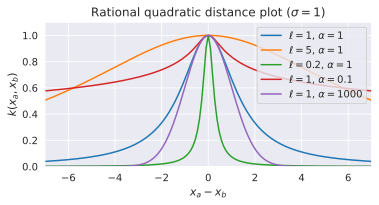

In [6]:
# Plot rational quadratic distance

xlim = (-7, 7)
X = np.expand_dims(np.linspace(*xlim, num=151), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $\\alpha=1$')
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=5., scale_mixture_rate=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=5$, $\\alpha=1$')
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=0.2, scale_mixture_rate=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=0.2$, $\\alpha=1$')
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=0.1).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $\\alpha=0.1$')
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=1000.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $\\alpha=1000$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$k(x_a,x_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

The following figure shows samples from the rational quadratic kernel together with a visual representation of its covariance matrix. The amplitude $\sigma$ is fixed to $1$ in all figures, changing the amplitude will have the same effect as changing the amplitude in the exponentiated quadratic.

Observe that in the previous and following figures, increasing the lengthscale parameter $\ell$ increases the overall spread of the covariance. Decreasing the scale-mixture $\alpha$ will allow for more minor local variations while still keeping the longer scale trends defined by the lengthscale parameter. Increasing the scale-mixture to a large value reduces the minor local variations.

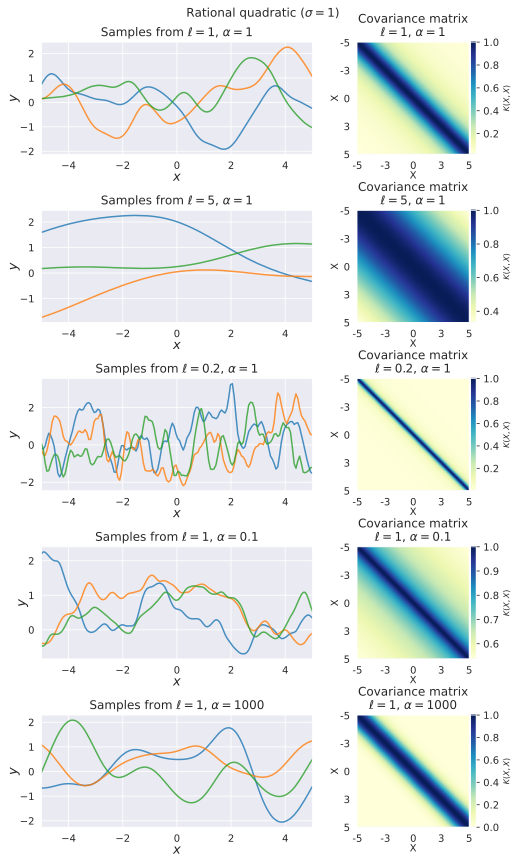

In [7]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-5, 5)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 12))
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.5)

# Plot first
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $\\alpha=1$',
    fig, gs[0], xlim)

# Plot second
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=5., scale_mixture_rate=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=5$, $\\alpha=1$',
    fig, gs[1], xlim)

# Plot third
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=0.2, scale_mixture_rate=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=0.2$, $\\alpha=1$',
    fig, gs[2], xlim)

# Plot fourth
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=0.1).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $\\alpha=0.1$',
    fig, gs[3], xlim)

# Plot fifth
Σ = tfk.RationalQuadratic(amplitude=1., length_scale=1., scale_mixture_rate=1000.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $\\alpha=1000$',
    fig, gs[4], xlim)

fig.suptitle('Rational quadratic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Periodic kernel

$$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{2}{\ell^2}\sin^2 \left( \pi \frac{\lvert x_a - x_b \rvert}{p}\right) \right)$$
With:
* $\sigma^2$ the overall variance ($\sigma$ is also known as amplitude).
* $\ell$ the lengthscale.
* $p$ the period, which is the distance between repetitions.

The [periodic kernel](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/ExpSinSquared) allows us to model [periodic functions](https://en.wikipedia.org/wiki/Periodic_function).


The periodic kernel is visualized in the next figures. The first two figures show the distance plot with respect to $0$: $k(0, x)$ with the amplitude $\sigma$ fixed to $1$ and different variations of the other parameters.

In [8]:
def periodic_tf(length_scale, period):
    """Periodic kernel TensorFlow operation."""
    amplitude_tf = tf.constant(1, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    period_tf = tf.constant(period, dtype=tf.float64)
    kernel = tfk.ExpSinSquared(
        amplitude=amplitude_tf,
        length_scale=length_scale_tf,
        period=period_tf)
    return kernel

def periodic(xa, xb, length_scale, period):
    """Evaluate periodic kernel."""
    kernel = periodic_tf(length_scale, period)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

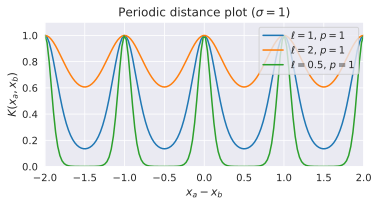

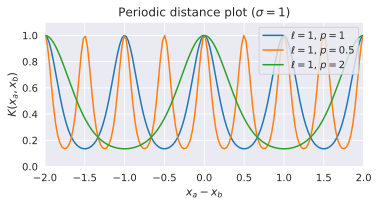

In [9]:
# Plot periodic distance

xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=150), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=2., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=2$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=0.5, period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()


# Second plot
fig, ax = plt.subplots(figsize=(5.4,3))

Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=0.5$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=2.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=2$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

The following figure shows samples from the periodic kernel together with a visual representation of its covariance matrix. The amplitude $\sigma$ is fixed to $1$ in all figures.

Observe that in the previous and following figures, increasing the period $p$ increases the distance between the repetitions (increasing the wavelength).
Increasing the lengthscale parameter $\ell$ decreases the local variations within a repetition in the same way that increasing the lengthscale in the exponentiated quadratic kernel decreases the variations over a longer range.

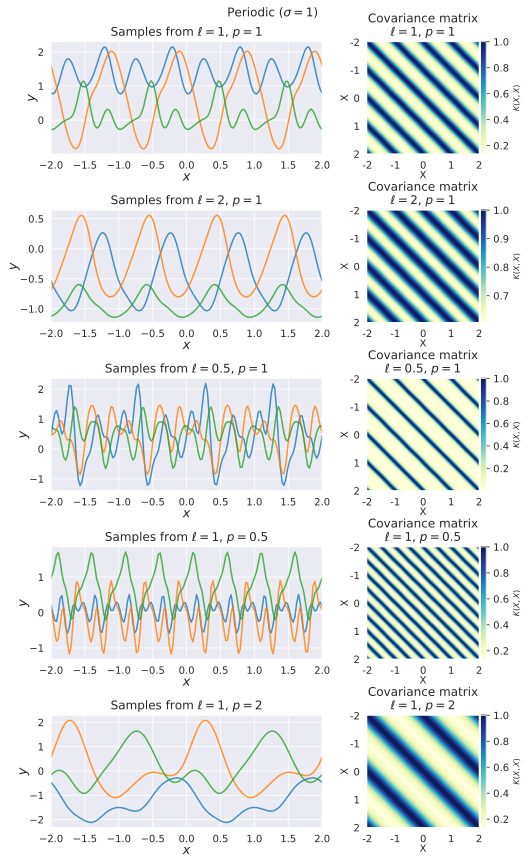

In [10]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 12))
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.5)

# Plot first
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $p=1$',
    fig, gs[0], xlim)

# Plot second
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=2., period=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=2$, $p=1$',
    fig, gs[1], xlim)

# Plot third
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=0.5, period=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=0.5$, $p=1$',
    fig, gs[2], xlim)

# Plot fourth
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=0.5).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $p=0.5$',
    fig, gs[3], xlim)

# Plot fifth
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=2.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell=1$, $p=2$',
    fig, gs[4], xlim)

fig.suptitle('Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Combining kernels by multiplication

Kernels can be combined by multiplying them together. Multiplying kernels is an elementwise multiplication of their corresponding covariance matrices. This means that the covariances of the two multiplied kernels will only have a high value if both covariances have a high value. The multiply operation can thus be interpreted as an AND operation.

### Local periodic kernel

The local periodic kernel is a multiplication of the periodic kernel with the exponentiated quadratic kernel to allow the periods to vary over longer distances. Note that the variance parameters $\sigma^2$ are combined into one.

$$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{2}{\ell_p^2}\sin^2 \left( \pi \frac{\lvert x_a - x_b \rvert}{p}\right) \right)
\exp \left(-\frac{ \left\Vert x_a - x_b \right\Vert^2}{2\ell_{eq}^2}\right)$$
With:
* $\sigma^2$ the overall variance ($\sigma$ is also known as amplitude).
* $\ell_p$ lengthscale of the periodic function.
* $p$ the period.
* $\ell_{eq}$ the lengthscale of the exponentiated quadratic.



In [11]:
def get_local_periodic_kernel(periodic_length_scale, period, amplitude, local_length_scale):
    periodic = tfk.ExpSinSquared(amplitude=amplitude, length_scale=periodic_length_scale, period=period)
    local = tfk.ExponentiatedQuadratic(length_scale=local_length_scale)
    return periodic * local

The local periodic kernel is visualized in the next figures. The first figure shows the distance plot with respect to $0$: $k(0, x)$ with only variations of the lengthscale of the exponentiated quadratic.

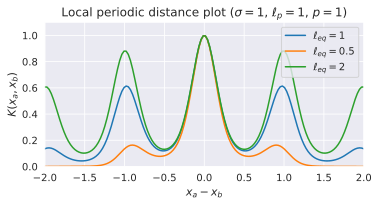

In [12]:
# Plot locally periodic distance
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=150), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=1$')
Σ = get_local_periodic_kernel(periodic_length_scale=1, period=1, amplitude=1, local_length_scale=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=0.5$')
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=2.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=2$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Local periodic distance plot ($\\sigma=1$, $\\ell_p=1$, $p=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

The following figure shows samples from the local periodic kernel together with a visual representation of its covariance matrix. Only variations of the lengthscale of the exponentiated quadratic $\ell_{eq}$ are shown, the rest of the parameters are fixed to $1$.

Observe that increasing the lengthscale parameter $\ell_{eq}$ increases the periodic covariance over a longer lengthscale and keeps the repetitions close to each other more consistent.

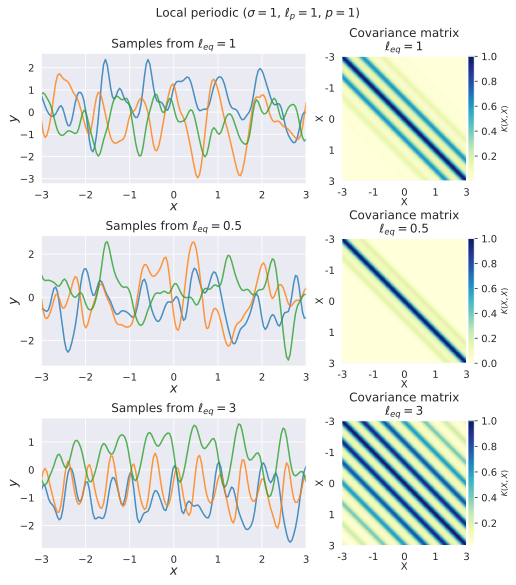

In [13]:
# Plot kernel matrix and samples of local periodic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 8))
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell_{eq}=1$',
    fig, gs[0], xlim)

# Plot second
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=0.5).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell_{eq}=0.5$',
    fig, gs[1], xlim)

# Plot third
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=3.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell_{eq}=3$',
    fig, gs[2], xlim)

fig.suptitle('Local periodic ($\\sigma=1$, $\\ell_p=1$, $p=1$)', y=0.99)
fig.subplots_adjust(left=0.07, bottom=0.05, right=0.93, top=0.91)
plt.show()
#

## Combining kernels by addition

Kernels can be combined by adding them together. Adding kernels is an elementwise addition of their corresponding covariance matrices. This means that the covariances of the two added kernels will only have a low value if both of the covariances have a low value. The addition operation can thus be interpreted as an OR operation.

###  Atmospheric CO₂ kernel

An example of a kernel combined by addition is the kernel we fitted in our [previous example]({% post_url /blog/gaussian_process/2019-01-06-gaussian-process-kernel-fitting %}) of fitting a Gaussian process on atmospheric CO₂ concentrations. This kernel needed to combine different characteristics of the data such as: long term smooth change in CO₂ levels, seasonality, and short to medium term irregularities.

The final kernel was defined as a sum of the exponentiated quadratic kernel, local periodic, and rational quadratic kernel plus observational white noise. The hyperparameters were fitted on the data using a maximum likelihood method.

The prior defined by this kernel with fitted hyperparameters is illustrated in the following figures. These figures will show some samples of the kernel and a visual representation of its covariance over different ranges of input.

In [14]:
def get_combined_kernel():
    smooth_kernel = tfk.ExponentiatedQuadratic(
        amplitude=107.26,
        length_scale=90.044)
    local_periodic_kernel = get_local_periodic_kernel(
        periodic_length_scale=1.65,
        period=1.,
        amplitude=3.07,
        local_length_scale=131.)
    irregular_kernel = tfk.RationalQuadratic(
        amplitude=1.,
        length_scale=1.38,
        scale_mixture_rate=0.111)
    return smooth_kernel + local_periodic_kernel + irregular_kernel


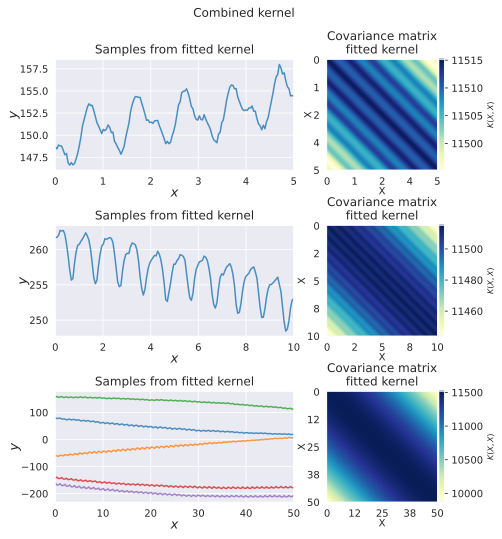

In [15]:
# Plot kernel matrix and samples of combined kernel

nb_of_samples = 150  # Number of test points.

# Start plotting
fig = plt.figure(figsize=(7, 8))
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.5)

# Plot first
nb_of_realizations = 1
xlim = (0, 5)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
Σ = get_combined_kernel().matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'fitted kernel', fig, gs[0], xlim)

# Plot second
nb_of_realizations = 1
xlim = (0, 10)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
Σ = get_combined_kernel().matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'fitted kernel', fig, gs[1], xlim)

# Plot third
nb_of_realizations = 5
xlim = (0, 50)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
Σ = get_combined_kernel().matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ,
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'fitted kernel', fig, gs[2], xlim)

fig.suptitle('Combined kernel', y=0.97)
plt.show()
#

This post was the last part of a series on Gaussian processes:

1. [Understanding Gaussian processes]({% post_url /blog/gaussian_process/2019-01-05-gaussian-process-tutorial %})
2. [Fitting a Gaussian process kernel]({% post_url /blog/gaussian_process/2019-01-06-gaussian-process-kernel-fitting %})
3. [Gaussian process kernels (this)]({% post_url /blog/gaussian_process/2019-01-07-gaussian-process-kernels %})

## References

1. [Gaussian Processes for Machine Learning. Chapter 4: Covariance Functions](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) by Carl Edward Rasmussen and Christopher K. I. Williams.
2. [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) by David Duvenaud.
3. [Kernel Design](http://gpss.cc/gpss15/talks/KernelDesign.pdf) GP Summer School, Sheffield, September 2015. By Nicolas Durrande.

In [ ]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.23.1

matplotlib            : 3.4.2
tensorflow            : 2.5.0
tensorflow_probability: 0.12.2
seaborn               : 0.11.1
numpy                 : 1.19.5



This post at <a rel="canonical" href="https://peterroelants.github.io/posts/gaussian-process-kernels/">peterroelants.github.io</a> is generated from an Python notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/main/notebooks/gaussian_process/gaussian-process-kernels.ipynb)